In [2]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
import cvxpy as cp
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from src.utilities import rho_reconstruction, rho_cat_state

# Task A

## A.1 Fock states

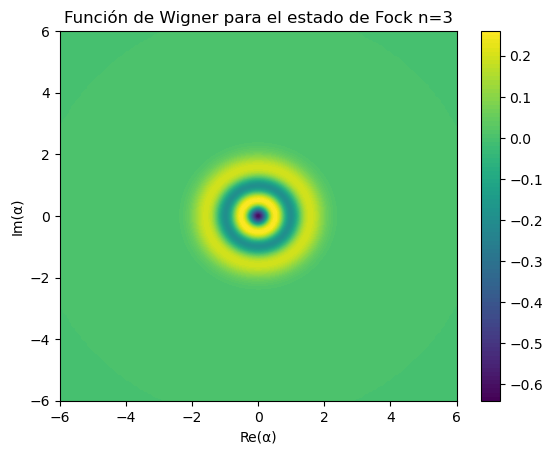

In [162]:
# Parámetros
N = 20  # Dimensión del espacio de Hilbert
n = 3   # Número de fotones

# Crear el estado de Fock
fock_state = dq.fock(N, n)

# Calcular la función de Wigner
xvec, yvec, W_fock = dq.wigner(fock_state)

# Graficar
plt.contourf(xvec, yvec, W_fock, 100)
plt.title(f"Función de Wigner para el estado de Fock n={n}")
plt.xlabel("Re(α)")
plt.ylabel("Im(α)")
plt.colorbar()
plt.show()

## A.2. Coherent states

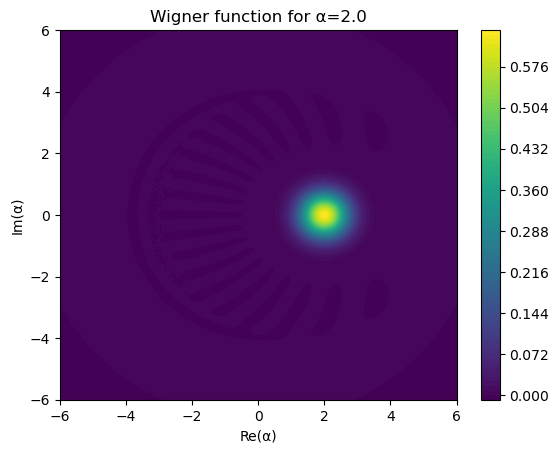

In [163]:
# Parámetros
alpha = 2.0  # Amplitud coherente

# Crear el estado coherente
coherent_state = dq.coherent(N, alpha)

# Calcular la función de Wigner
xvec, yvec, W_coherent = dq.wigner(coherent_state)

# Graficar
plt.contourf(xvec, yvec, W_coherent.T, 100)
plt.title(f"Wigner function for α={alpha}")
plt.xlabel("Re(α)")
plt.ylabel("Im(α)")
plt.colorbar()
plt.show()

## A.3. Cat states

### A.3.1 2-Cat states

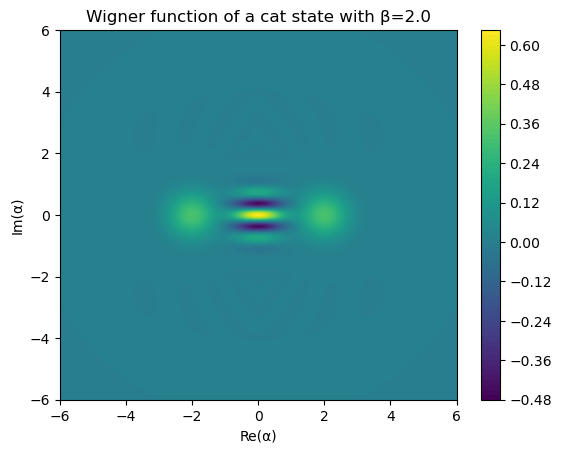

In [164]:
# Parámetros
beta = 2.0  # Amplitud coherente para los estados superpuestos

# Crear los estados coherentes
coh_plus = dq.coherent(N, beta)
coh_minus = dq.coherent(N, -beta)

# Crear el estado de gato (superposición simétrica)
cat_state = (coh_plus + coh_minus) / jnp.sqrt(2)

# Calcular la función de Wigner
xvec, yvec, W_cat = dq.wigner(cat_state)

# Graficar
plt.contourf(xvec, yvec, W_cat.T, 100)
plt.title(f"Wigner function of a cat state with β={beta}")
plt.xlabel("Re(α)")
plt.ylabel("Im(α)")
plt.colorbar()
plt.show()

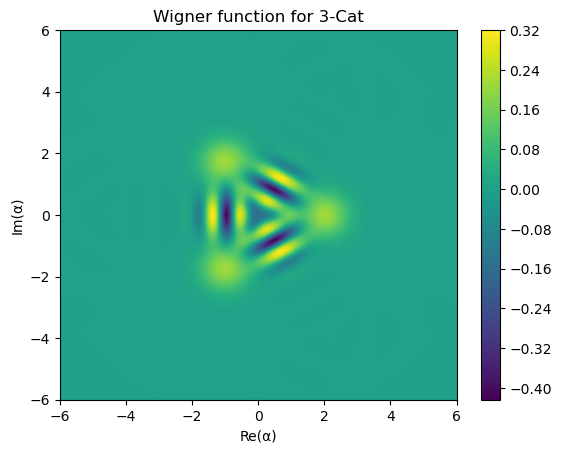

In [165]:
# Parámetros
N = 30
alpha = 2.0

# Fases para los tres estados coherentes
phases = [0, 2 * jnp.pi / 3, 4 * jnp.pi / 3]

# Crear y sumar los estados coherentes
coh_states = [dq.coherent(N, alpha * jnp.exp(1j * phi)) for phi in phases]
unnormalized_3cat = sum(coh_states)

# Normalizar la superposición
cat_3 = dq.unit(unnormalized_3cat)

# Calcular la función de Wigner
xvec, yvec, W_cat_3 = dq.wigner(cat_3)

# Graficar
plt.contourf(xvec, yvec, W_cat_3.T, 100)
plt.title("Wigner function for 3-Cat")
plt.xlabel("Re(α)")
plt.ylabel("Im(α)")
plt.colorbar()
plt.show()

|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
|██████████| 100.0% ◆ elapsed 01m15s ◆ remaining 0.00ms  


GIF guardado en ./wigner_dissipative_cat.gif


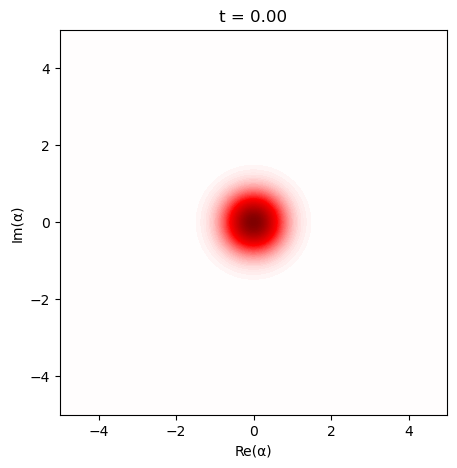

In [166]:
# ─── PARÁMETROS ───────────────────────────────────────────────────────────────
N_a, N_b    = 30, 30      # Hilbert dimensions for mode a and b
g2          = 1.0
epsilon_b   = -4.0
kappa_b     = 10.0
T_final     = 4.0
n_steps     = 100

# ─── OPERADORES BÁSICOS ────────────────────────────────────────────────────────
# Operadores de aniquilación de un solo modo
a = dq.destroy(N_a)
b = dq.destroy(N_b)

# Creation operators
adag = dq.dag(a)
bdag = dq.dag(b)

# Identidades
I_a = dq.eye(N_a)
I_b = dq.eye(N_b)

# Producto tensorial en el espacio de Hilbert conjunto
a_tot    = dq.tensor(a,     I_b)
adag_tot = dq.tensor(adag,  I_b)
b_tot    = dq.tensor(I_a,   b)
bdag_tot = dq.tensor(I_a,  bdag)

# ─── HAMILTONIANO ──────────────────────────────────────────────────────────────
H = (
    jnp.conjugate(g2) * adag_tot @ adag_tot @ b_tot
  + g2                 * a_tot    @ a_tot    @ bdag_tot
  + jnp.conjugate(epsilon_b) * b_tot
  + epsilon_b               * bdag_tot
)

# ─── ESTADO INICIAL ────────────────────────────────────────────────────────────
psi0_a = dq.fock(N_a, 0)
psi0_b = dq.fock(N_b, 0)
psi0   = dq.tensor(psi0_a, psi0_b)

# ─── OPERADORES DE COLAPSO (DISIPADORES) ───────────────────────────────────────
c_ops = [ jnp.sqrt(kappa_b) * b_tot ]

# ─── MALLA TEMPORAL Y RESOLUCIÓN DE LA ECUACIÓN MAESTRA ───────────────────────
times = jnp.linspace(0., T_final, n_steps)
result = dq.mesolve(H, c_ops, psi0, times)
# ─── CÁLCULO DE LAS FUNCIONES DE WIGNER PARA EL MODO a ─────────────────────────
# Se realiza la traza parcial sobre el modo b en cada instante de tiempo

wigner_frames = []
for rho_ab in result.states:
    rho_a = dq.ptrace(rho_ab, keep=(0,), dims=(N_a, N_b))
    xvec, yvec, W = dq.wigner(rho_a, xmax=5.0, ymax=5.0, npixels=200)
    wigner_frames.append(W)

# ─── CREACIÓN Y GUARDADO DEL GIF ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(5, 5))
def update(frame):
    ax.clear()
    cont = ax.contourf(xvec, yvec, wigner_frames[frame], levels=100, cmap='seismic', vmin=-max(abs(wigner_frames[frame].min()), abs(wigner_frames[frame].max())), vmax=max(abs(wigner_frames[frame].min()), abs(wigner_frames[frame].max())))
    ax.set_title(f"t = {times[frame]:.2f}")
    ax.set_xlabel("Re(α)")
    ax.set_ylabel("Im(α)")
    return [cont]

ani = animation.FuncAnimation(fig, update, frames=n_steps, blit=False)
ani.save("wigner_dissipative_cat.gif", writer="pillow", fps=10)

print("GIF guardado en ./wigner_dissipative_cat.gif")

# Task B

## B.1. Digital data

In [ ]:
# Parameters
N = 30
N_fit = 100
xvec = np.linspace(-5, 5, 200)
pvec = np.linspace(-5, 5, 200)
grid = np.linspace(-3, 3, 11)
alpha_list = [x + 1j*y for x in grid for y in grid]

# Define test kets
test_states = {
    'fock_n3': dq.fock(N, 3),
    'coherent': dq.coherent(N, 1.2 + 0.5j),
    'cat2': dq.unit(dq.coherent(N, 1.2 + 0.5j) + dq.coherent(N, -1.2 - 0.5j)),
    'cat3': dq.unit(sum(
        dq.coherent(N, 1.2 + 0.5j * np.exp(1j * 2 * np.pi * k / 3))
        for k in range(3)))
}

# Run tomography + evaluation using wigner_fn
for name, psi in test_states.items():
    rho_true = psi @ psi.dag()
    _, _, W_jax = dq.wigner(psi, xvec=xvec, yvec=pvec)
    W_grid = np.asarray(W_jax)

    rho_rec, w_k, E_ops, metrics = rho_reconstruction(
        W_grid=W_grid,
        xvec=xvec,
        pvec=pvec,
        alpha_list=alpha_list,
        N_psi=N,
        N_fit=N_fit,
        rho_true=rho_true
    )

    print(f"{name}:")
    print(f"  fidelity   = {metrics['fidelity']:.4f}")
    print(f"  trace_dist = {metrics['trace_dist']:.4f}")
    print(f"  HS_dist    = {metrics['HS_dist']:.4f}")
    print(f"  purity_rec = {metrics['purity_rec']:.4f}")
    print(f"  Δpurity    = {metrics['delta_purity']:.4f}")
    print(f"  eig_true   (top3) = {metrics['eig_true'][:3]}")
    print(f"  eig_rec    (top3) = {metrics['eig_rec'][:3]}\n")

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:91: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())
/Users/joancaceres/anaconda3/envs/ayb_env/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


fock_n3:
  fidelity   = 0.9866
  trace_dist = 0.0137
  HS_dist    = 0.0147
  purity_rec = 0.9735
  Δpurity    = 0.0265
  eig_true   (top3) = [1. 0. 0.]
  eig_rec    (top3) = [0.98664504 0.00387808 0.0022766 ]

coherent:
  fidelity   = 0.9975
  trace_dist = 0.0230
  HS_dist    = 0.0306
  purity_rec = 0.9941
  Δpurity    = 0.0059
  eig_true   (top3) = [1.0000004e+00 2.6912680e-08 5.9067968e-09]
  eig_rec    (top3) = [9.9705696e-01 2.5737891e-04 1.8382141e-04]

cat2:
  fidelity   = 0.9929
  trace_dist = 0.0124
  HS_dist    = 0.0141
  purity_rec = 0.9859
  Δpurity    = 0.0141
  eig_true   (top3) = [1.0000000e+00 3.4296532e-10 2.4454106e-16]
  eig_rec    (top3) = [9.929278e-01 3.366372e-03 7.817271e-04]

cat3:
  fidelity   = 0.9920
  trace_dist = 0.0338
  HS_dist    = 0.0433
  purity_rec = 0.9850
  Δpurity    = 0.0150
  eig_true   (top3) = [1.0000000e+00 1.1340861e-08 1.6339783e-09]
  eig_rec    (top3) = [9.9248421e-01 3.9828653e-03 2.3982844e-04]



  0%|          | 0/10 [00:00<?, ?it/s]

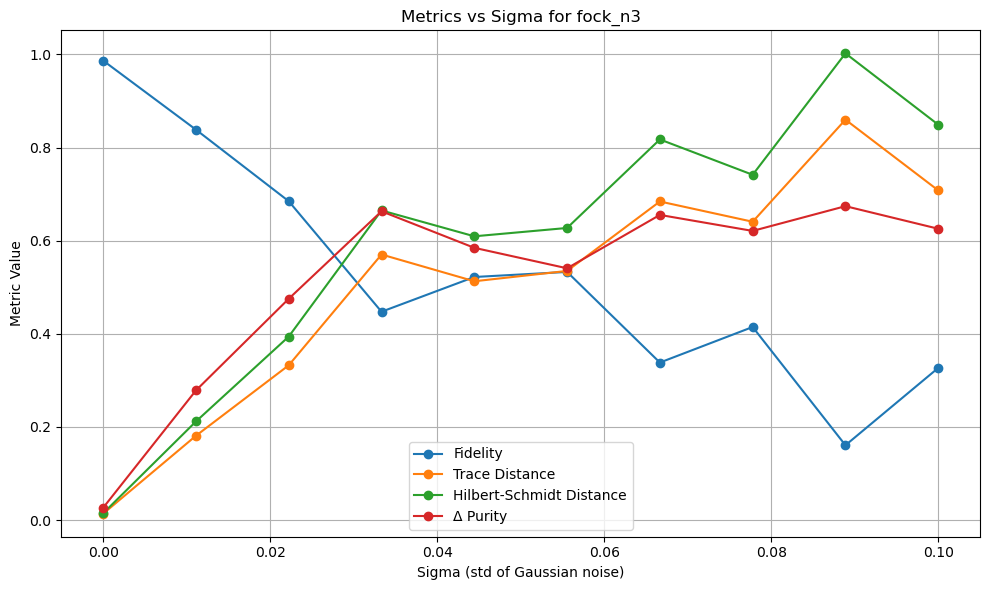

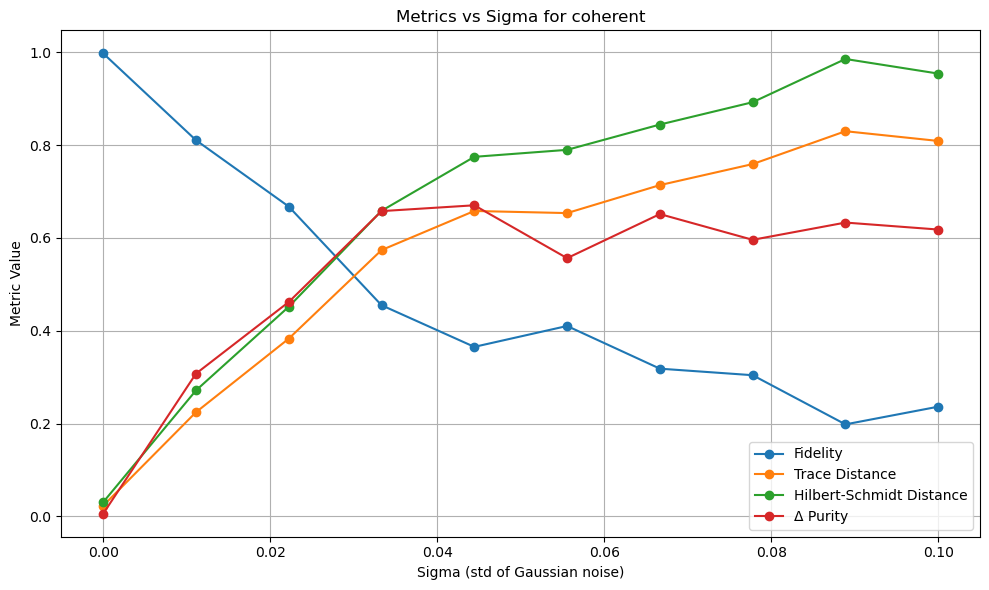

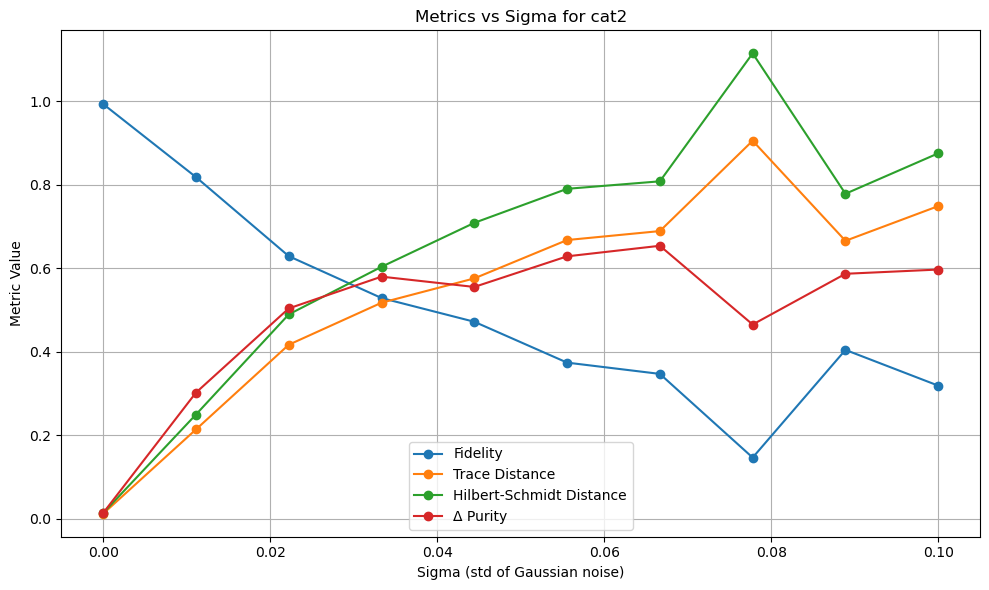

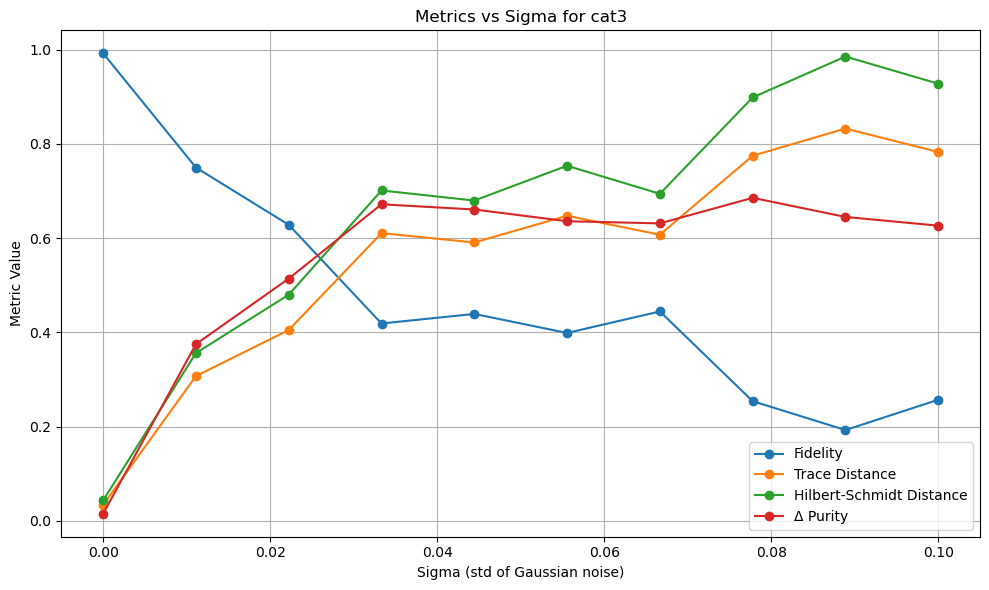

In [ ]:
# Parámetros
N = 30
N_fit = 100
xvec = np.linspace(-5, 5, 200)
pvec = np.linspace(-5, 5, 200)
grid = np.linspace(-3, 3, 11)
alpha_list = [x + 1j*y for x in grid for y in grid]

# Estados de prueba
test_states = {
    'fock_n3': dq.fock(N, 3),
    'coherent': dq.coherent(N, 1.2 + 0.5j),
    'cat2': dq.unit(dq.coherent(N, 1.2 + 0.5j) + dq.coherent(N, -1.2 - 0.5j)),
    'cat3': dq.unit(sum(
        dq.coherent(N, 1.2 + 0.5j * np.exp(1j * 2 * np.pi * k / 3))
        for k in range(3)))
}

# Diccionario para guardar métricas
metrics_data = {name: {'sigma': [], 'fidelity': [], 'trace_dist': [], 'HS_dist': [], 'delta_purity': []}
                for name in test_states.keys()}

# Valores de sigma (desviación estándar del ruido gaussiano)
sigma_values = np.linspace(0.0, 0.1, 10)

# Loop principal
for sigma in tqdm(sigma_values):
    for name, psi in test_states.items():
        rho_true = psi @ psi.dag()
        
        # Calcular Wigner ideal
        _, _, W_jax = dq.wigner(psi, xvec=xvec, yvec=pvec)
        W_grid = np.asarray(W_jax)
        
        # Añadir ruido gaussiano
        noisy_W = W_grid + np.random.normal(loc=0.0, scale=sigma, size=W_grid.shape)

        # Tomografía
        rho_rec, w_k, E_ops, metrics = rho_reconstruction(
            W_grid= noisy_W,
            xvec=xvec,
            pvec=pvec,
            alpha_list=alpha_list,
            N_psi=N,
            N_fit=N_fit,
            rho_true=rho_true
        )

        # Guardar métricas
        metrics_data[name]['sigma'].append(sigma)
        metrics_data[name]['fidelity'].append(metrics['fidelity'])
        metrics_data[name]['trace_dist'].append(metrics['trace_dist'])
        metrics_data[name]['HS_dist'].append(metrics['HS_dist'])
        metrics_data[name]['delta_purity'].append(metrics['delta_purity'])

# Graficar resultados
for name, data in metrics_data.items():
    plt.figure(figsize=(10, 6))
    plt.plot(data['sigma'], data['fidelity'], label='Fidelity', marker='o')
    plt.plot(data['sigma'], data['trace_dist'], label='Trace Distance', marker='o')
    plt.plot(data['sigma'], data['HS_dist'], label='Hilbert-Schmidt Distance', marker='o')
    plt.plot(data['sigma'], data['delta_purity'], label='Δ Purity', marker='o')
    plt.title(f"Metrics vs Sigma for {name}")
    plt.xlabel("Sigma (std of Gaussian noise)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## B.2. Real data

In [1]:
# Directory containing the pickle files
data_dir = 'data/experimental/'

# Dictionary to store the loaded data
loaded_data = {}

# Iterate over all files in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith('.pickle'):
        file_path = os.path.join(data_dir, file_name)
        with open(file_path, 'rb') as file:
            try:
                xvec, pvec, W_grid = pickle.load(file)
                loaded_data[file_name.replace('.pickle', '')] = {
                    'xvec': xvec,
                    'pvec': pvec,
                    'Wigner': W_grid
                }
            except Exception as e:
                print(f"Error loading {file_name}: {e}")

# Verify the loaded files
print(f"Loaded files: {list(loaded_data.keys())}")

NameError: name 'os' is not defined

In [4]:
N = 30

# Fock zero state
psi = dq.fock(N, 0)
rho_fock_zero = psi @ psi.dag()

# Fock one state
psi = dq.fock(N, 1)
rho_fock_one = psi @ psi.dag()

# Cat plus state
rho_cat_plus = rho_cat_state(N=N, alpha=np.sqrt(2.5), sign='+')

# Cat minus state
rho_cat_minus = rho_cat_state(N=N, alpha=np.sqrt(2.5), sign='-')

# Cat plus 5.6 state
rho_cat_plus_56 = rho_cat_state(N=N, alpha=np.sqrt(5.6), sign='+')

# Cat plus 11.3 state
rho_cat_plus_113 = rho_cat_state(N=N, alpha=np.sqrt(11.3), sign='+')

rho_target_dict = {
    'fock_0': rho_fock_zero,
    'fock_1': rho_fock_one,
    'cat_plus': rho_cat_plus,
    'cat_minus': rho_cat_minus,
    'cat_plus_56': rho_cat_plus_56,
    'cat_plus_113': rho_cat_plus_113
}

### B.2.1. Fock zero

In [6]:
# Parameters
N_fit = 200

xvec = loaded_data['wigner_fock_zero']['xvec']
pvec = loaded_data['wigner_fock_zero']['pvec']
W_grid = loaded_data['wigner_fock_zero']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)
alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_fock_zero, w_k, E_ops, fock_zero_metrics = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_true=rho_target_dict['fock_0']
)

fock_zero_metrics

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:142: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())


TomographyMetrics(
  fidelity: 0.867891,
  trace_dist: 0.138234,
  HS_dist: 0.187505,
  purity_rec: 0.770941,
  eig_true: [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
  eig_rec: [ 8.6900e-01,  1.2550e-01,  5.5014e-03,  2.9974e-06,  2.1463e-06,
  1.9134e-06,  1.4722e-06,  1.2488e-06,  1.1097e-06,  8.9609e-07,
  7.7620e-07,  6.1740e-07,  3.9990e-07,  2.6772e-07,  1.7122e-07,
  1.4580e-07,  1.0035e-07, -2.8208e-08, -9.8719e-08, -2.8321e-07,
 -3.6232e-07, -5.5578e-07, -5.5978e-07, -7.3426e-07, -1.0132e-06,
 -1.1728e-06, -1.3143e-06, -1.6903e-06, -2.0065e-06, -2.5449e-06]
)

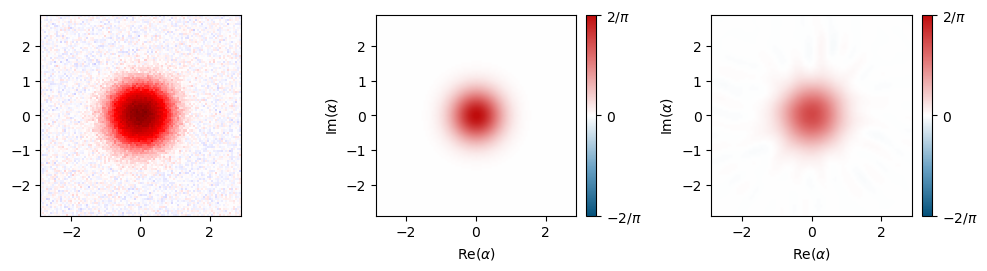

In [7]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].set_aspect('equal')
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax, shading='auto')
dq.plot.wigner(rho_target_dict['fock_0'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_fock_zero, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.2. Fock one

In [8]:
# Parameters
N = 30
N_fit = 200

xvec = loaded_data['wigner_fock_one']['xvec']
pvec = loaded_data['wigner_fock_one']['pvec']
W_grid = loaded_data['wigner_fock_one']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_fock_1, w_k, E_ops, metrics_fock_1 = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_true=rho_target_dict['fock_1']
)

metrics_fock_1


/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:142: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())


TomographyMetrics(
  fidelity: 0.518733,
  trace_dist: 0.482641,
  HS_dist: 0.633111,
  purity_rec: 0.438297,
  eig_true: [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
  eig_rec: [ 5.1992e-01,  4.0795e-01,  3.2422e-02,  1.6007e-02,  1.1886e-02,
  1.0320e-02,  1.5829e-03,  3.3465e-05,  2.6140e-05,  1.6008e-05,
  1.0490e-05,  5.6075e-06,  4.1843e-06,  3.2112e-06,  2.4258e-06,
  7.1730e-08, -1.2819e-06, -2.0443e-06, -3.0553e-06, -3.9816e-06,
 -4.5228e-06, -6.3100e-06, -7.9087e-06, -9.4286e-06, -1.0419e-05,
 -1.2782e-05, -1.9405e-05, -2.1915e-05, -3.3286e-05, -5.3141e-05]
)

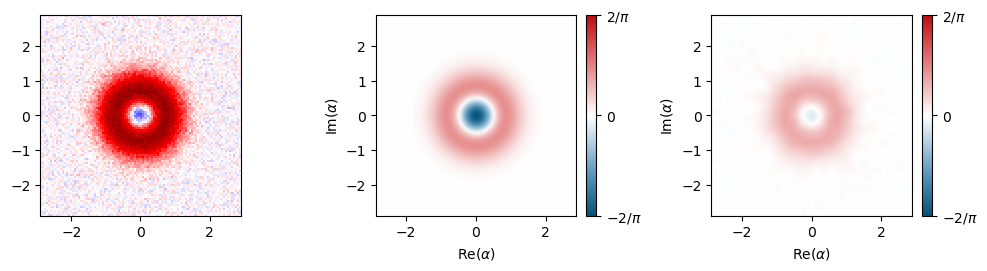

In [10]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['fock_1'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_fock_1, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.3. Cat plus

In [11]:
# Parameters
N_fit = 200

xvec = loaded_data['wigner_cat_plus']['xvec']
pvec = loaded_data['wigner_cat_plus']['pvec']
W_grid = loaded_data['wigner_cat_plus']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus, w_k, E_ops, metrics_cat_plus = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_true=rho_target_dict['cat_plus'],
    max_iters=1000,
)

metrics_cat_plus

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:142: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())


TomographyMetrics(
  fidelity: 0.678971,
  trace_dist: 0.352538,
  HS_dist: 0.459748,
  purity_rec: 0.568111,
  eig_true: [ 1.0000e+00,  6.3894e-09,  2.8452e-10,  2.7506e-11,  1.4220e-13,
  2.8553e-14,  1.1662e-17,  1.5905e-19,  1.8854e-26,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.0910e-21,
 -5.0910e-21, -4.2433e-14, -1.4684e-12, -1.5686e-09, -5.9778e-09],
  eig_rec: [ 6.9541e-01,  2.9036e-01,  1.4228e-02,  1.9525e-06,  1.3724e-06,
  1.2277e-06,  1.0434e-06,  9.4414e-07,  8.5912e-07,  7.0491e-07,
  5.1428e-07,  4.4168e-07,  3.9002e-07,  3.1642e-07,  1.5803e-07,
  5.9990e-08,  1.9162e-08, -7.1608e-08, -1.5370e-07, -3.1274e-07,
 -3.9321e-07, -4.9367e-07, -5.5850e-07, -6.7563e-07, -8.8887e-07,
 -9.7339e-07, -1.0741e-06, -1.2877e-06, -1.4783e-06, -2.2612e-06]
)

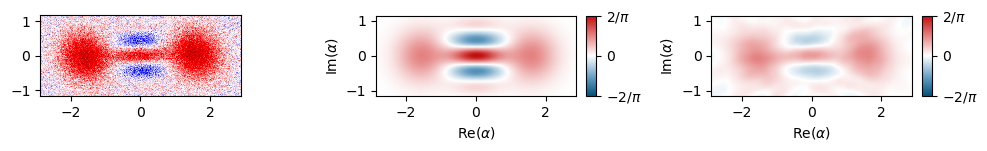

In [12]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_plus'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.4. Cat minus

In [13]:
# Parameters
N = 30
N_fit = 200

xvec = loaded_data['wigner_cat_minus']['xvec']
pvec = loaded_data['wigner_cat_minus']['pvec']
W_grid = loaded_data['wigner_cat_minus']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_minus, w_k, E_ops, metrics_cat_minus = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_true=rho_target_dict['cat_minus'],
    max_iters=1000,
)

metrics_cat_minus

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:142: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())


TomographyMetrics(
  fidelity: 0.609292,
  trace_dist: 0.422543,
  HS_dist: 0.561115,
  purity_rec: 0.532542,
  eig_true: [ 1.0000e+00,  3.7471e-09,  1.7652e-11,  1.5345e-15,  8.7364e-16,
  3.8179e-20,  1.6254e-20,  1.3361e-28,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4059e-24, -3.4906e-17,
 -1.9416e-16, -2.2494e-14, -3.9427e-11, -9.5627e-09, -1.9963e-08],
  eig_rec: [ 6.4334e-01,  3.4423e-01,  1.2436e-02,  5.4280e-06,  4.8876e-06,
  3.3402e-06,  2.2694e-06,  2.0405e-06,  1.8473e-06,  1.2700e-06,
  1.0671e-06,  5.9179e-07,  3.7506e-07,  1.7974e-07, -2.6666e-09,
 -4.2097e-07, -4.8405e-07, -7.5459e-07, -9.3616e-07, -1.0991e-06,
 -1.3592e-06, -1.6954e-06, -1.8551e-06, -2.1413e-06, -2.6530e-06,
 -2.8804e-06, -3.1188e-06, -4.0309e-06, -5.4424e-06, -6.3348e-06]
)

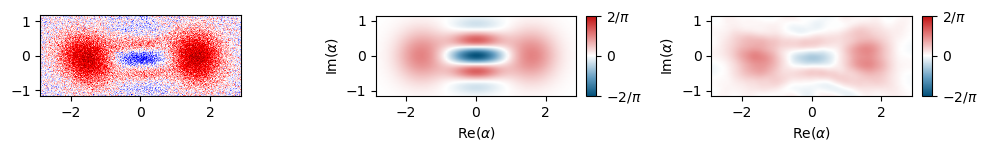

In [14]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_minus'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_minus, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.4. Cat plus 56

In [15]:
# Parameters
N = 30
N_fit = 200
    
xvec = loaded_data['wigner_cat_plus_56']['xvec']
pvec = loaded_data['wigner_cat_plus_56']['pvec']
W_grid = loaded_data['wigner_cat_plus_56']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus_56, w_k, E_ops, metrics_cat_plus_56 = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_true=rho_target_dict['cat_plus_56'],
    max_iters=1000,
)

metrics_cat_plus_56

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:142: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())


TomographyMetrics(
  fidelity: 0.525212,
  trace_dist: 0.556112,
  HS_dist: 0.695544,
  purity_rec: 0.533225,
  eig_true: [ 1.0000e+00,  1.1618e-08,  2.0325e-09,  5.8684e-10,  8.0609e-11,
  4.5102e-11,  5.4850e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00, -5.6836e-19, -1.0810e-16, -3.0481e-16,
 -1.3092e-12, -1.2761e-10, -4.8282e-09, -6.4123e-09, -2.2308e-08],
  eig_rec: [ 6.2888e-01,  3.7112e-01,  3.2901e-06,  1.5134e-06,  1.0997e-06,
  7.6526e-07,  6.3790e-07,  5.1391e-07,  4.0614e-07,  2.8370e-07,
  2.2288e-07,  8.9004e-08,  1.4797e-09, -1.1089e-08, -9.0081e-08,
 -1.4707e-07, -1.8870e-07, -2.2488e-07, -3.1937e-07, -3.6684e-07,
 -3.9788e-07, -4.7350e-07, -5.1130e-07, -6.0955e-07, -6.8734e-07,
 -8.9356e-07, -9.6419e-07, -1.3404e-06, -1.5136e-06, -3.0896e-06]
)

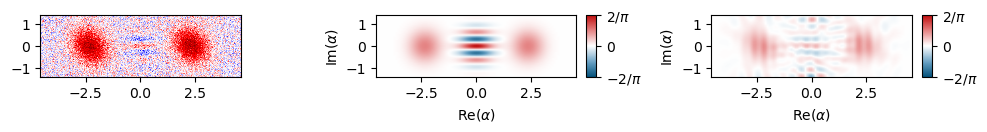

In [16]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_plus_56'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus_56, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

In [17]:
# Parameters
N = 30
N_fit = 200

    
xvec = loaded_data['wigner_cat_plus_113']['xvec']
pvec = loaded_data['wigner_cat_plus_113']['pvec']
W_grid = loaded_data['wigner_cat_plus_113']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus_113, w_k, E_ops, metrics_cat_plus_113 = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_true=rho_target_dict['cat_plus_113'],
    max_iters=1000,
)

metrics_cat_plus_113

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:142: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E_ops_big = [0.5 * (I_big + dq.displace(N_fit, alpha) @ P_big @ dq.displace(N_fit, alpha).dag())


TomographyMetrics(
  fidelity: 0.487492,
  trace_dist: 0.540314,
  HS_dist: 0.725572,
  purity_rec: 0.500839,
  eig_true: [ 1.0000e+00,  6.3582e-09,  6.3582e-09,  2.0644e-09,  2.0644e-09,
  7.0503e-10,  9.1985e-11,  1.8190e-12,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
  0.0000e+00,  0.0000e+00,  0.0000e+00, -8.0481e-12, -2.2940e-11,
 -3.8126e-10, -1.0264e-09, -1.0264e-09, -2.8286e-09, -1.0764e-08],
  eig_rec: [ 5.2009e-01,  4.7994e-01,  1.6140e-05,  1.4230e-05,  5.6407e-06,
  4.7045e-06,  2.6434e-06,  2.2263e-06,  1.7958e-06,  1.4107e-06,
  5.1845e-07,  3.1376e-07,  1.5578e-07,  1.1027e-08, -7.5047e-08,
 -1.2421e-07, -2.9438e-07, -3.7959e-07, -6.0581e-07, -9.6797e-07,
 -1.2230e-06, -2.0761e-06, -2.6732e-06, -2.8172e-06, -3.3169e-06,
 -4.9825e-06, -1.3953e-05, -1.5131e-05, -1.6429e-05, -1.8461e-05]
)

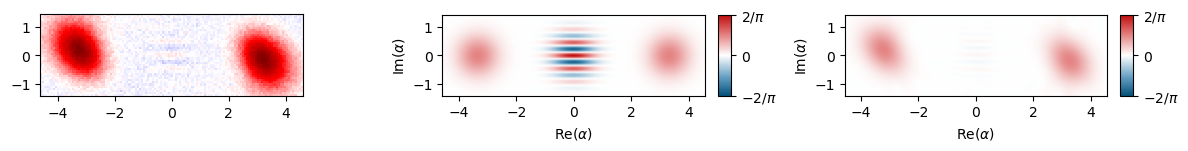

In [18]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(12, 6))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_plus_113'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus_113, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()